In [8]:
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
data = pd.read_csv('meditando.csv')
eeg = data['Dev1/ai0'].to_numpy()
ecg = data['Dev1/ai1'].to_numpy()
N = len(eeg)
fm = int(1/0.002)
sig_time =N/fm
time = np.linspace(0,sig_time,N)

In [248]:
def eeg_plot(s,ti,tf):
    plt.figure(figsize=(20,6))
    N = len(s)
    fm = int(1/0.002)
    sig_time =N/fm
    time = np.linspace(0,sig_time,N)
    time_cut = time[int(ti*fm):int(tf*fm)]
    s_cut = s[int(ti*fm):int(tf*fm)]*1000 #señal en el tiempo deseado en uV
    plt.plot(time_cut,s_cut,'blue')
    plt.xlabel('tiempo [s]')
    plt.ylabel('Amplitud [uV]')
    plt.title(f'Señal EEG t = [{ti},{tf}]')
    #plt.grid()
    return

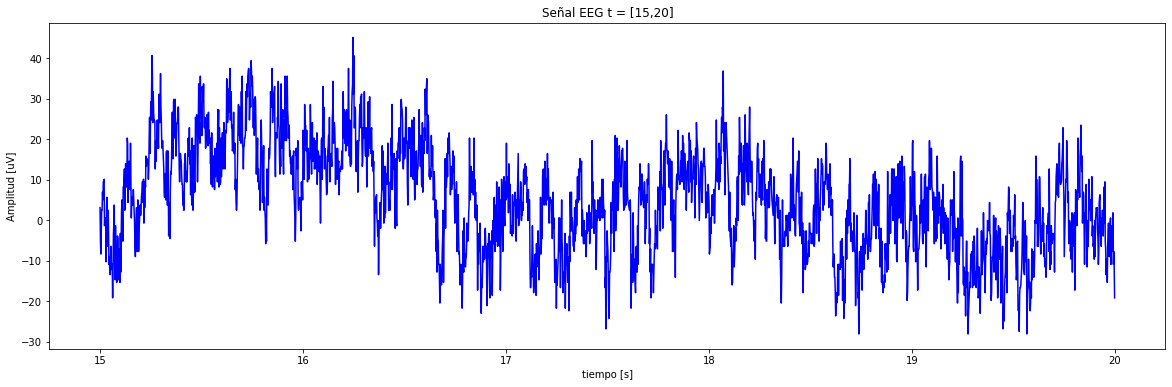

In [249]:
eeg_plot(eeg,15,20)

In [136]:

def morlet2(fecx,wide,freqm):
    frecm=freqm
    twav = np.linspace(-2,2,frecm*4)
    #Sine wave
    com_sin = np.exp(1j*2*np.pi*fecx*twav)
    #Gauss wave
    sigma = wide/(2*np.pi*fecx)
    gauss_c = np.exp(-twav**2/(2*sigma**2))
    #Normalization
    A_sigma = 1/(np.sqrt(sigma*np.sqrt(np.pi)))
    #Morlet wavelet
    wavelet = A_sigma*com_sin*gauss_c
    return wavelet

def morlet(fecx,wide,freqm):
    frecm=freqm
    twav = np.linspace(-2,2,frecm*4)
    #Sine wave
    com_sin = np.exp(1j*2*np.pi*fecx*twav)
    #Gauss wave
    sigma = wide/(2*np.pi*fecx)
    gauss_c = np.exp(-twav**2/(2*sigma**2))
    #Normalization
    A_sigma = 1/(np.sqrt(sigma*np.sqrt(np.pi)))
    #Morlet wavelet
    wavelet = com_sin*gauss_c
    return wavelet

In [123]:
def FFT(signal,freqm,xlim):
    N = len(signal)
    T = 1.0/freqm
    signal_fft = sc.fft.fft(signal)
    frequen = sc.fft.fftfreq(N, T)[:N//2]
    plt.plot(frequen, 2.0/N * np.abs(signal_fft[:N//2]),c='red')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Potencia')
    plt.xlim([0.1,xlim])
    #plt.ylim([0,1])
    plt.grid()
    plt.title('Transformada de Fourier')
    plt.show()
    return

In [36]:
def MRA(sig,fi,ff,freq_int,wavelet,freqm):
    #Freq - cycles
    range_cycles = [4,10] #barrido de número de ciclos
    delta = ff-fi #intervalo de frecuencias de descomposición
    num_frq = int(delta*(1/freq_int)) # número de frecuencias en que se descompone
    vfrec = np.linspace(fi,ff,num_frq) #vector de frecuencias
    num_cycles =np.logspace(np.log10(range_cycles[0]), np.log10(range_cycles[-1]),num_frq) #vector de ciclos
    #Preparation
    n,m = len(sig),len(wavelet(vfrec[0],range_cycles[0],freqm))
    p = n+m-1
    k = num_frq
    half_wav = int(np.floor(m/2))
    matrx_pad = np.zeros([k,p])
    sig_fft = sc.fft.fft(np.pad(sig,(0,p-n),'constant'))
    #Convolution
    conv_mat = np.zeros([k,n])
    for i in range(k):
        wave = np.pad(wavelet(vfrec[i],num_cycles[i],freqm), (0,n+1),'constant')
        wave_fft = sc.fft.fft(wave) 
        wave_fft = wave_fft / wave_fft.max()
        conv_res_prim = np.multiply(sig_fft,wave_fft)
        conv_res = abs(sc.fft.ifft(conv_res_prim))**2 #resultado 
        conv_res = conv_res[half_wav:-half_wav] #recorte del padding
        for j in range(n):
            conv_mat[i][j] = conv_res[j]
    return conv_mat

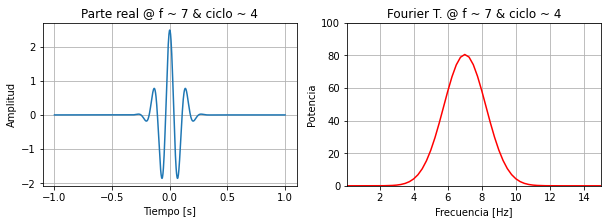

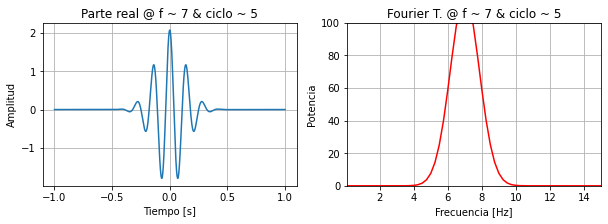

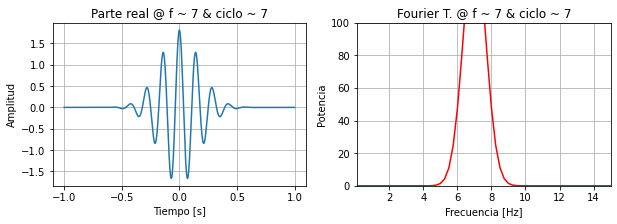

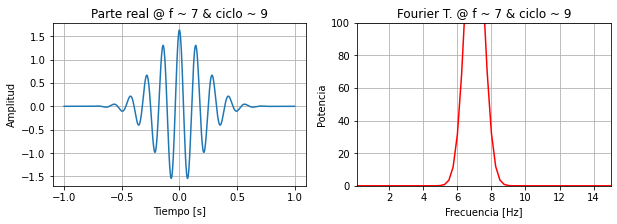

In [133]:
frecm = 500
twav = np.linspace(-2,2,frecm*4)
fi = 2
ff = 10
freq_int = 2
range_cycles = [4,20] #barrido de número de ciclos
delta = ff-fi #intervalo de frecuencias de descomposición
num_frq = int(delta*(1/freq_int)) # número de frecuencias en que se descompone
vfrec = np.linspace(fi,ff,num_frq)
vfrec2 = np.zeros(num_frq)
N = len((morlet(vfrec[0],num_cycles[0],500)))
T = 1/500
fwav = sc.fft.fftfreq(N, T)[:N//2]
for j in range(len(vfrec)):
    vfrec2[j] = 7
num_cycles =np.logspace(np.log10(range_cycles[0]), np.log10(range_cycles[-1]),num_frq) #vector de ciclos
num_cycles2 =np.linspace(range_cycles[0],range_cycles[-1],10)
for i in range(len(vfrec)):
    fig,axs = plt.subplots(1,2,figsize=(10,3))
    axs[0].plot(twav[frecm:frecm*3],np.real(morlet(vfrec2[i],num_cycles2[i],500))[frecm:frecm*3])
    axs[0].set_title(f'Parte real @ f ~ {int(vfrec2[i])} & ciclo ~ {int(num_cycles2[i])}') 
    axs[0].set_ylabel('Amplitud')
    axs[0].set_xlabel('Tiempo [s]')
    axs[1].plot(fwav, 2.0/N * abs(sc.fft.fft(morlet(vfrec2[i],num_cycles2[i],500))[:N//2])**2,'red')
    axs[1].set_title(f'Fourier T. @ f ~ {int(vfrec2[i])} & ciclo ~ {int(num_cycles2[i])}') 
    axs[1].set_ylabel('Potencia')
    axs[1].set_xlabel('Frecuencia [Hz]')
    axs[1].set_xlim([0.1,15])
    axs[1].set_ylim([0,100])
    axs[0].grid()
    axs[1].grid()
plt.show()

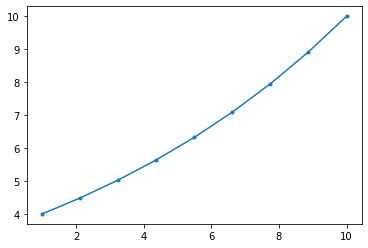

In [45]:
plt.plot(vfrec,num_cycles,'.-')

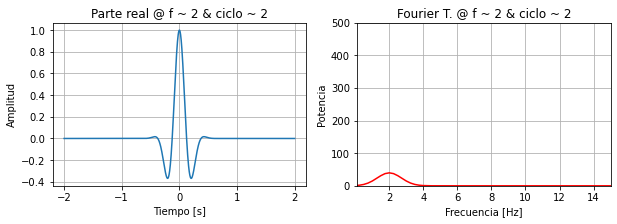

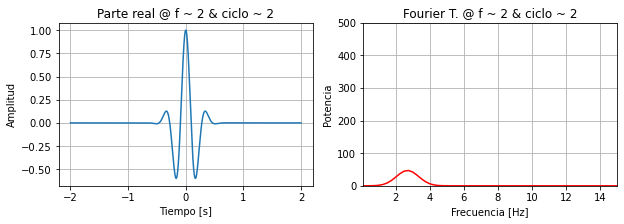

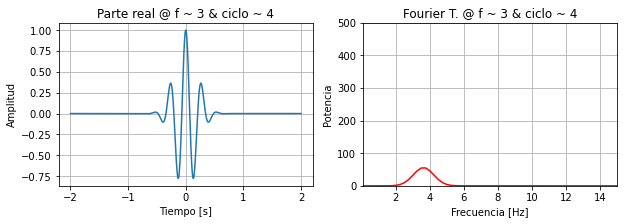

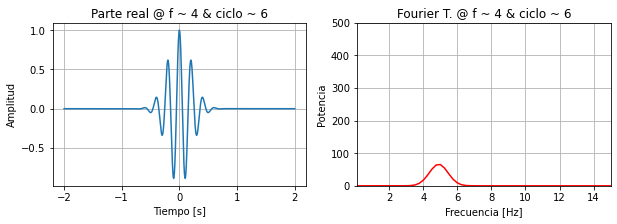

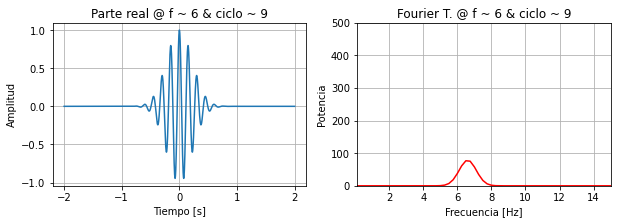

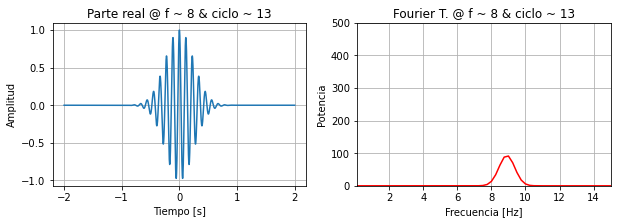

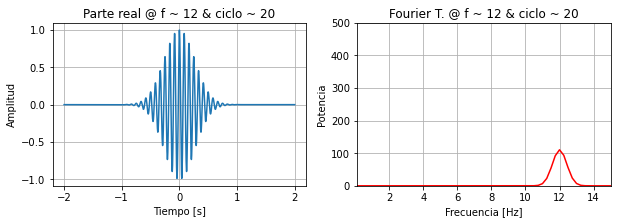

In [257]:
frecm = 500
twav = np.linspace(-2,2,frecm*4)
fi = 2
ff = 12
freq_int = np.log10(20)
range_cycles = [2,20] #barrido de número de ciclos
delta = ff-fi #intervalo de frecuencias de descomposición
num_frq = int(delta*(1/freq_int)) # número de frecuencias en que se descompone
#vfrec = np.linspace(fi,ff,num_frq)
vfrec = np.logspace(np.log10(fi),np.log10(ff),num_frq)
vfrec2 = np.zeros(num_frq)
N = len((morlet(vfrec[0],num_cycles[0],500)))
T = 1/500
fwav = sc.fft.fftfreq(N, T)[:N//2]
for j in range(len(vfrec)):
    vfrec2[j] = 7
num_cycles =np.logspace(np.log10(range_cycles[0]), np.log10(range_cycles[-1]),num_frq) #vector de ciclos
num_cycles2 =np.linspace(range_cycles[0],range_cycles[-1],10)
for i in range(len(vfrec)):
    fig,axs = plt.subplots(1,2,figsize=(10,3))
    axs[0].plot(twav,np.real(morlet(vfrec[i],num_cycles[i],500)))
    axs[0].set_title(f'Parte real @ f ~ {int(vfrec[i])} & ciclo ~ {int(num_cycles[i])}') 
    axs[0].set_ylabel('Amplitud')
    axs[0].set_xlabel('Tiempo [s]')
    axs[1].plot(fwav, 2.0/N * abs(sc.fft.fft(morlet(vfrec[i],num_cycles[i],500))[:N//2])**2,'red')
    axs[1].set_title(f'Fourier T. @ f ~ {int(vfrec[i])} & ciclo ~ {int(num_cycles[i])}') 
    axs[1].set_ylabel('Potencia')
    axs[1].set_xlabel('Frecuencia [Hz]')
    axs[1].set_xlim([0.1,15])
    axs[1].set_ylim([0,500])
    axs[0].grid()
    axs[1].grid()
plt.show()

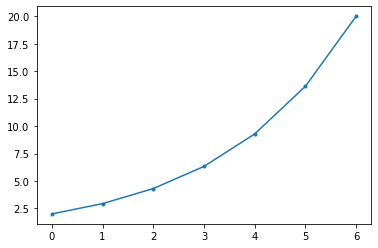

In [259]:
plt.plot(num_cycles,'.-')

In [120]:
def integrate_gauss(f,vf,delta):
    half_int = 0
    n = len(f)
    vmax,vmax_i = 0,0
    for i in range(n):
        half_int += f[i]
        if f[i] == f.max():
            vmax = f[i]
            vmax_i = i
            break
        else:
            continue
    total_int = total_int*2
    integrate = 0
    for j in range(n):
        integrate += f[vmax_i+j]

In [127]:
import scipy.integrate as integrate

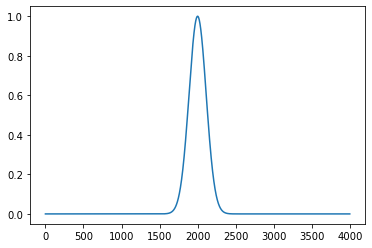

In [232]:
result = integrate.simps(abs(morlet(7,7,800))**2)
result2 = integrate.simps(abs(morlet2(7,7,800))**2)
plt.plot(abs(morlet(7,7,1000))**2)

In [240]:
t_delta= np.linspace(0,1,500)
def delta(s,t):
    n = len(t)
    frecm = t[-1]/n
    i_s = s/frecm
    delta = np.zeros(n)
    for i in range(n):
        if i != i_s:
            delta[i] = 0
        else:
            delta[i] = 1
    return delta
def const(a,t):
    n=len(t)
    frecm = t[-1]/n
    const = np.zeros(n)
    for i in range(n):
        const[i] = a
    return const
const_t = const(1,t_delta)    
delta_t = delta(0.5,t_delta)

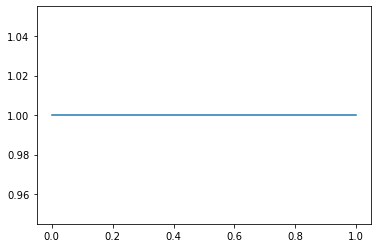

In [241]:
plt.plot(t_delta,const_t)

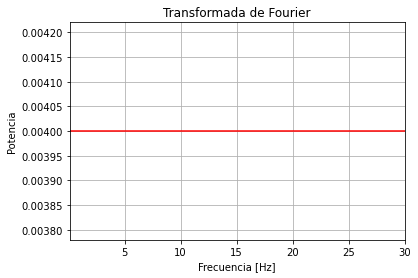

In [238]:
FFT(delta_t,500,30)

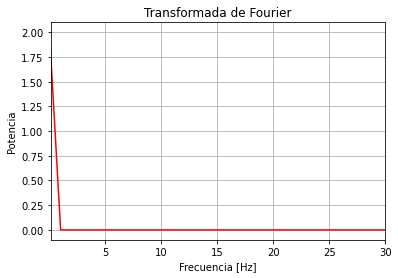

In [242]:
FFT(const_t,500,30)